### 导入了所需的库
#### 包括 PyTorch、Torchvision、Matplotlib、Numpy、日志记录、警告管理和 TQDM 进度条库等。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import logging
import warnings
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format='\033[1;37m%(message)s\033[0m')
logger = logging.getLogger()

### 这段代码定义了一个名为 AdvancedNet 的卷积神经网络。
#### 该网络包含四个卷积层和三个全连接层。每个卷积层后面都有一个 ReLU 激活函数和一个最大池化层。最后两个全连接层之间还包含了 Dropout 层，以防止过拟合。

In [2]:
# 定义一个更复杂的模型结构
class AdvancedNet(nn.Module):
    def __init__(self):
        super(AdvancedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)  # 增加Dropout比例
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 512*4*4)  # 展平处理
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

##### 这段代码确保模型运行在 GPU（如果可用）或 CPU 上。这样可以加速训练过程。

In [3]:
# 确保设备（GPU或CPU）正确设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# 确保模型定义在 .to(device) 之前
model = AdvancedNet()
model = model.to(device)

True


### 定义了交叉熵损失函数和 AdamW 优化器。交叉熵损失函数常用于分类任务，AdamW 是一种常用的优化器，具有权重衰减功能，可以有效地防止过拟合。

In [4]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)  # 调整学习率

### 定义了图像的预处理和数据增强步骤。包括图像尺寸调整、随机水平翻转、随机旋转、颜色抖动、随机仿射变换、转为 Tensor 和随机擦除等操作。最后，对图像进行标准化。

In [5]:
# 数据预处理和增强
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 增加图像尺寸
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # 随机擦除
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### 加载训练、验证和测试数据集，并进行数据拆分。使用 DataLoader 将数据集转换为可以迭代的数据加载器。

In [6]:
# 加载数据集并进行交叉验证拆分
dataset = torchvision.datasets.ImageFolder(root='melanoma_cancer_dataset/train', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)  # 将 num_workers 设置为 0
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)    # 将 num_workers 设置为 0

test_dataset = torchvision.datasets.ImageFolder(root='melanoma_cancer_dataset/test', transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)  # 将 num_workers 设置为 0

#### 定义学习率调度器，使用 OneCycleLR 调度器动态调整学习率，以提高训练效果。

In [7]:
# 定义学习率调度器
num_epochs = 20
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.003, steps_per_epoch=len(train_loader), epochs=num_epochs)

#### 定义早停机制的参数。当验证损失在指定次数的训练周期内不再降低时，提前停止训练，以防止过拟合。

In [8]:
# 定义早停机制
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')

#### 初始化用于存储训练和验证过程中的损失、准确率、召回率和 F1 分数的列表。

In [9]:
# 训练和验证记录
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

#### 定义并绘制数据集分布图，以显示训练、验证和测试数据集中的每个类别的样本数量。

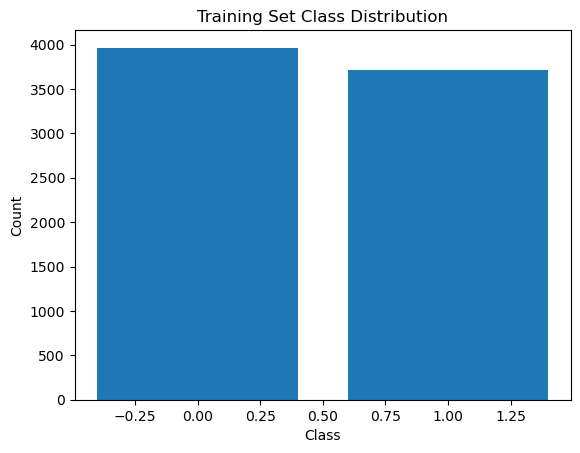

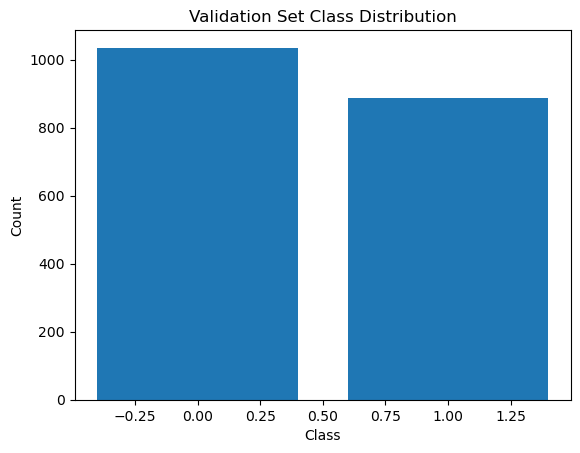

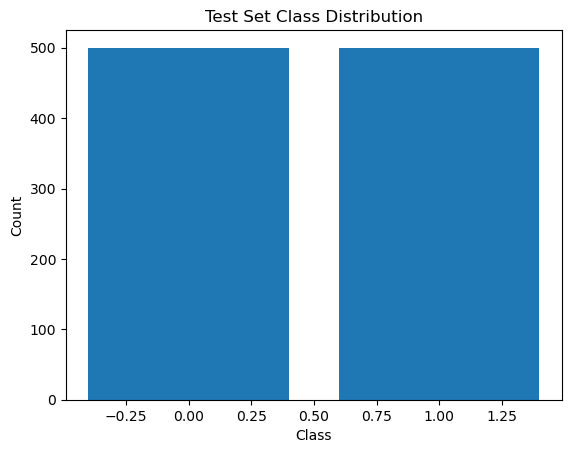

In [10]:
# 数据集分布图
def plot_class_distribution(loader, title):
    class_counts = {}
    for _, labels in loader:
        for label in labels:
            label = label.item()
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure()
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()
    plt.close()

plot_class_distribution(train_loader, 'Training Set Class Distribution')
plot_class_distribution(val_loader, 'Validation Set Class Distribution')
plot_class_distribution(test_loader, 'Test Set Class Distribution')

### 在每个训练周期内：

##### 训练模式下，计算损失和预测值，更新模型权重。
##### 记录训练损失、准确率、召回率和 F1 分数。
##### 验证模式下，计算损失和预测值，记录验证损失、准确率、召回率和 F1 分数。
##### 使用学习率调度器调整学习率。
##### 根据早停机制决定是否提前停止训练。
##### 打印当前轮次的损失和准确率。
##### 绘制并显示当前轮次的训练和验证损失曲线、准确率曲线、召回率曲线和 F1 分数曲线。

Epoch 1/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.58it/s]
Epoch 1/20, Train Loss: 0.5810, Val Loss: 0.4360, Train Acc: 68.92%, Val Acc: 79.70%


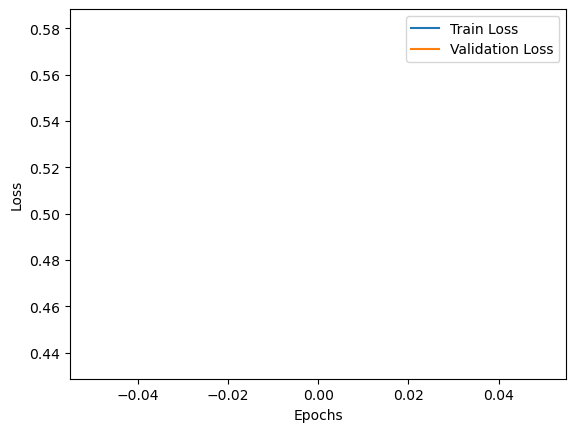

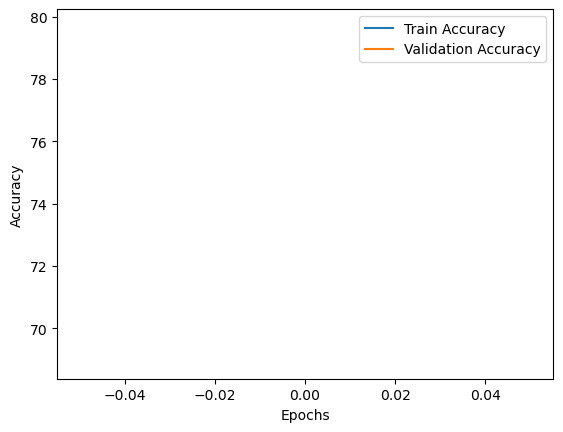

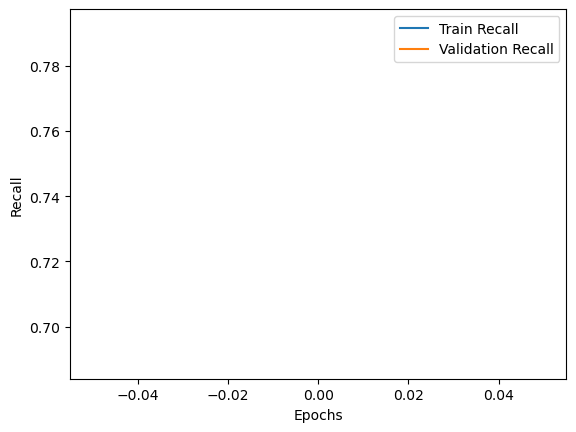

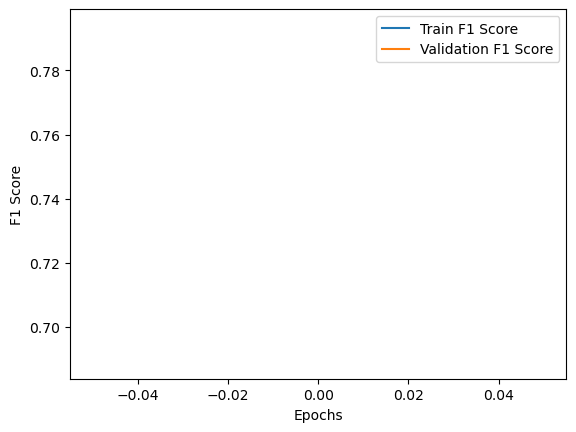

Epoch 2/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  5.04it/s]
Epoch 2/20, Train Loss: 0.4210, Val Loss: 0.3999, Train Acc: 81.22%, Val Acc: 82.30%


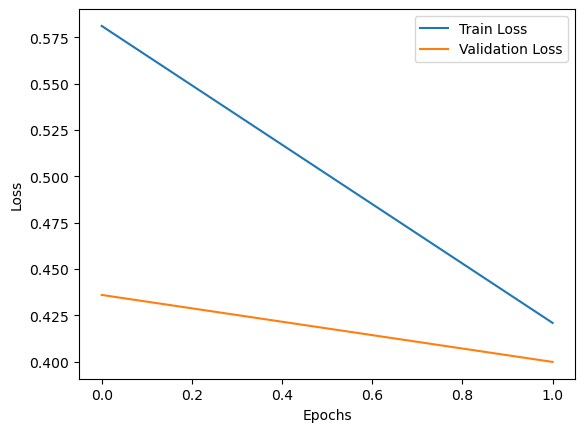

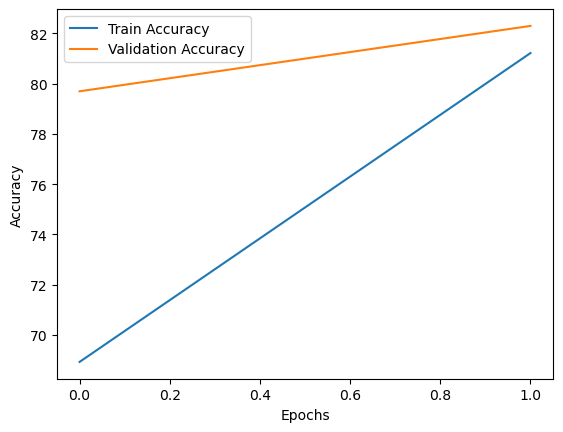

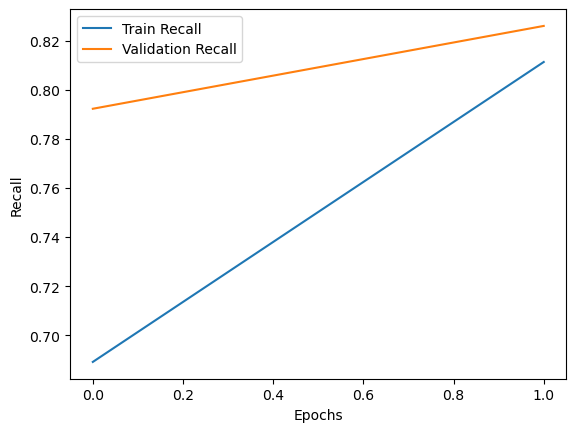

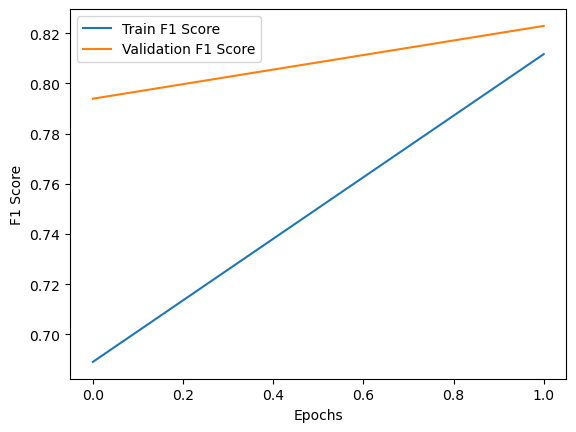

Epoch 3/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.62it/s]
Epoch 3/20, Train Loss: 0.4058, Val Loss: 0.3488, Train Acc: 81.95%, Val Acc: 84.96%


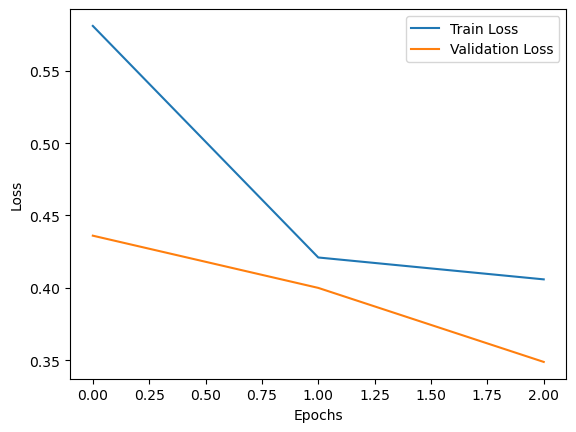

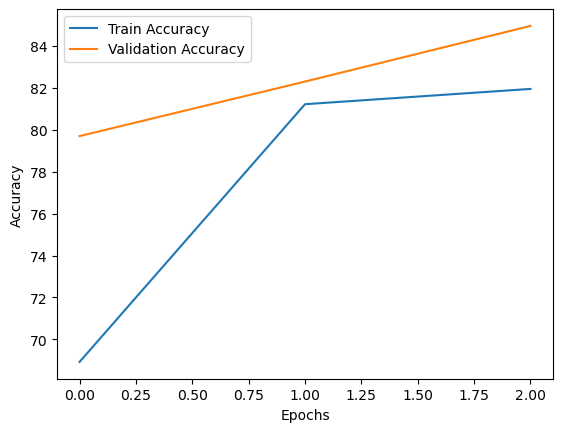

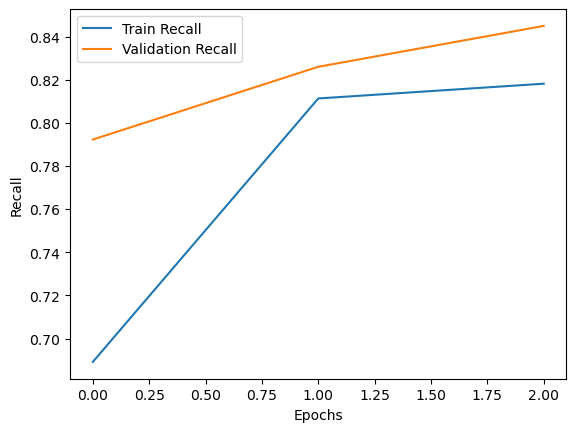

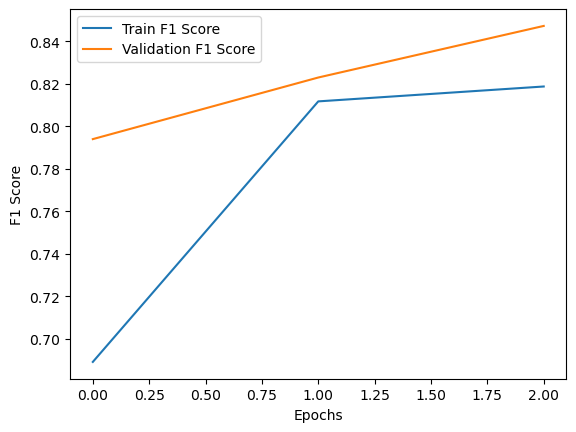

Epoch 4/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.61it/s]
Epoch 4/20, Train Loss: 0.3605, Val Loss: 0.3558, Train Acc: 84.33%, Val Acc: 84.33%


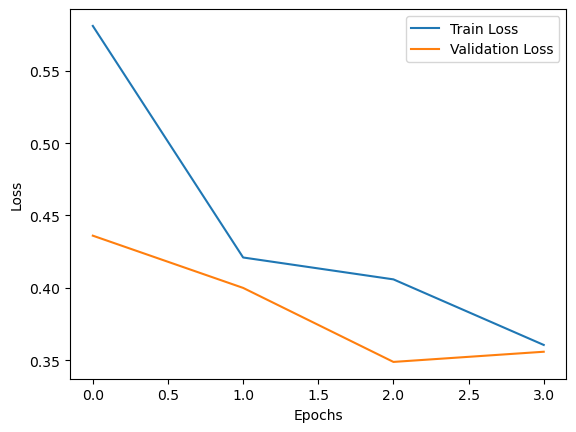

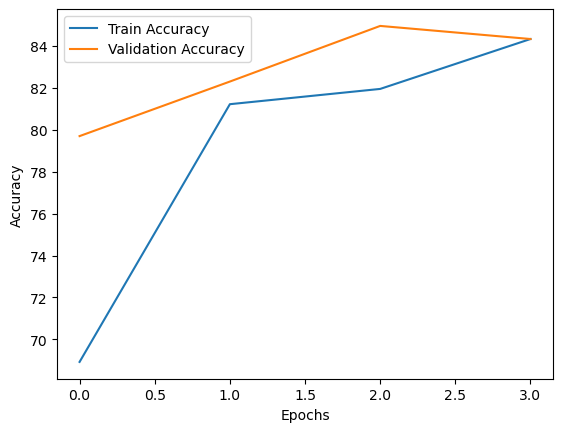

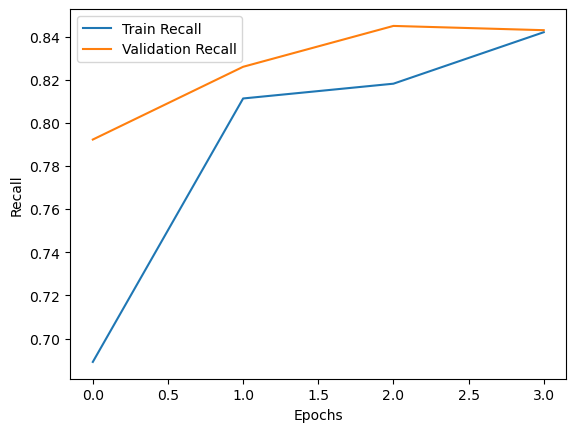

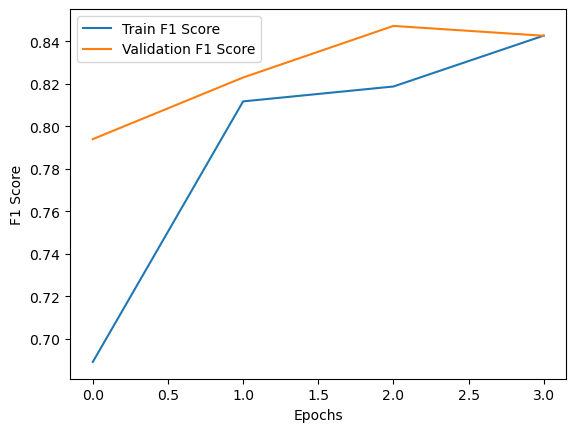

Epoch 5/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.62it/s]
Epoch 5/20, Train Loss: 0.3510, Val Loss: 0.3342, Train Acc: 85.03%, Val Acc: 84.75%


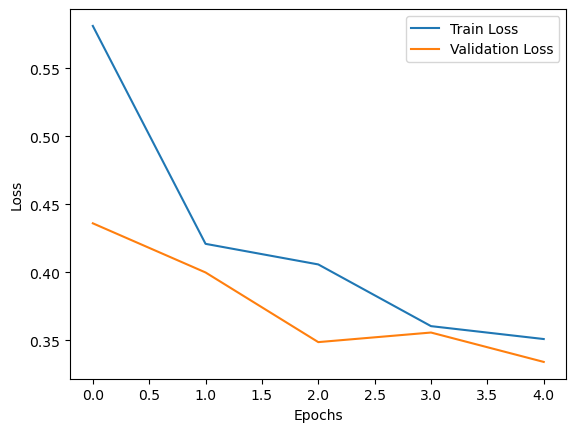

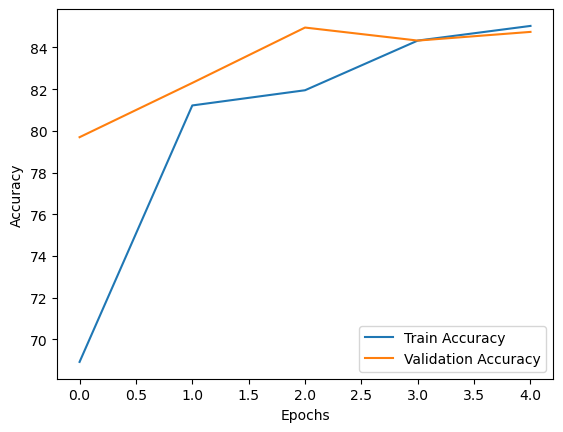

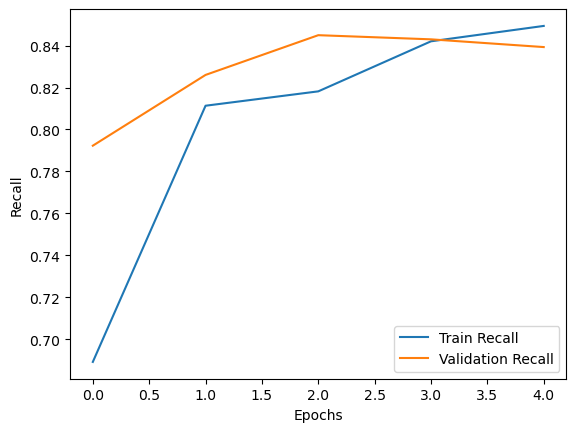

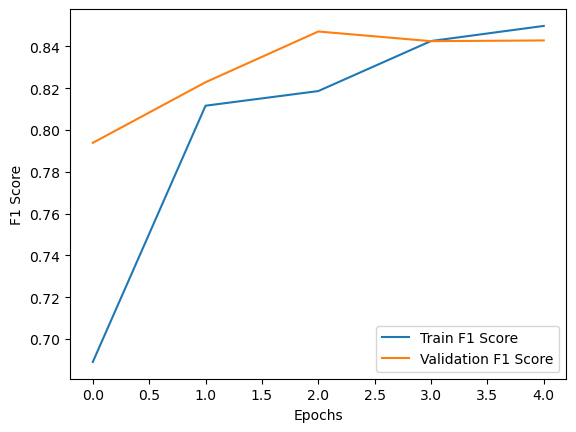

Epoch 6/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.62it/s]
Epoch 6/20, Train Loss: 0.3308, Val Loss: 0.3531, Train Acc: 86.35%, Val Acc: 84.17%


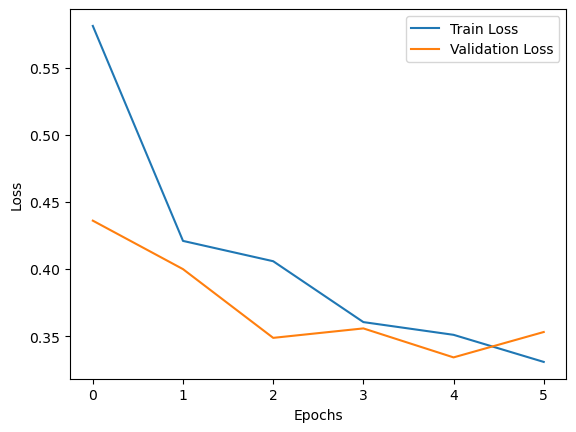

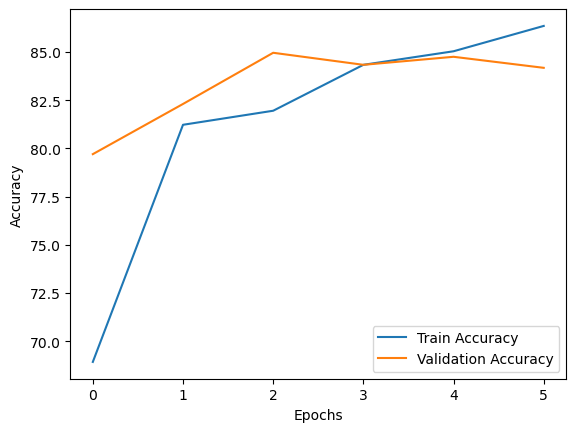

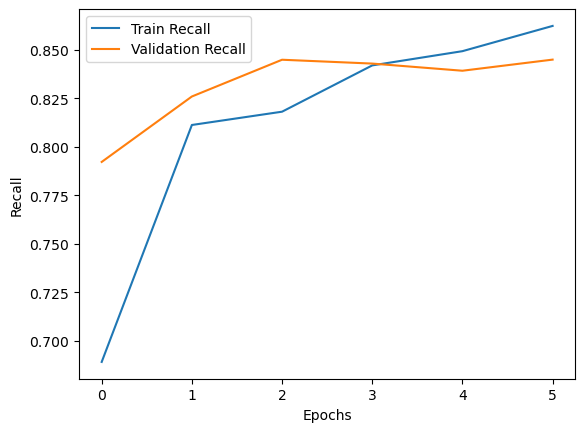

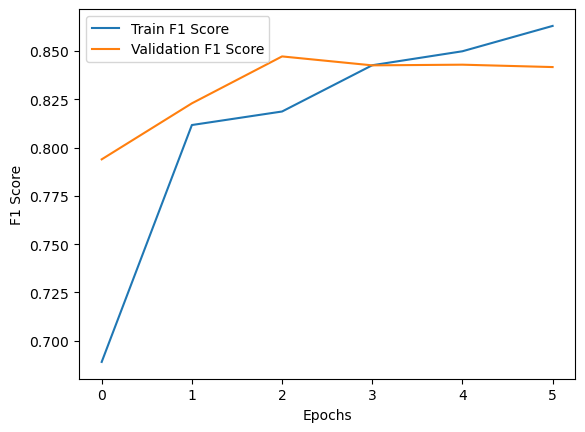

Epoch 7/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.74it/s]
Epoch 7/20, Train Loss: 0.3428, Val Loss: 0.3179, Train Acc: 85.22%, Val Acc: 85.37%


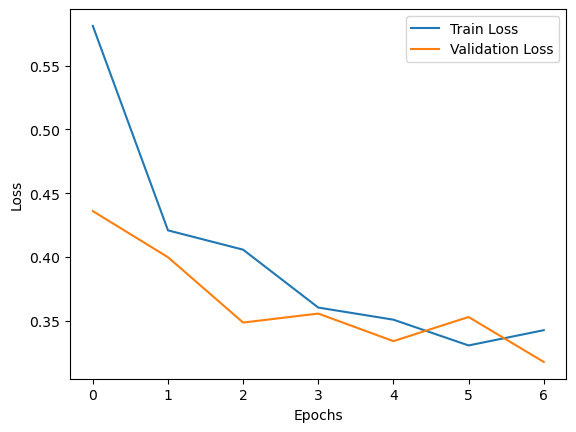

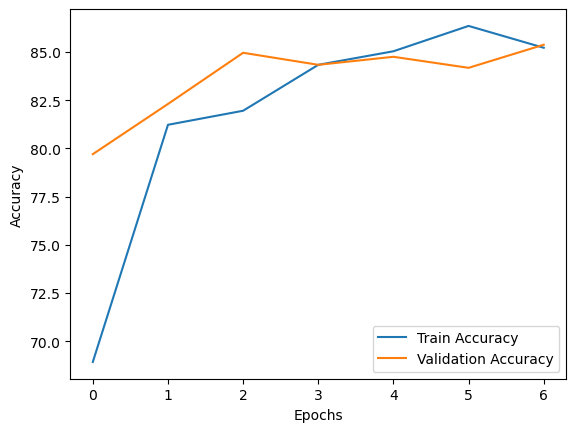

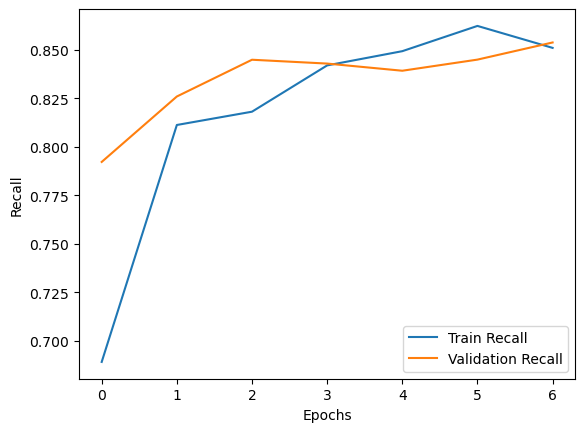

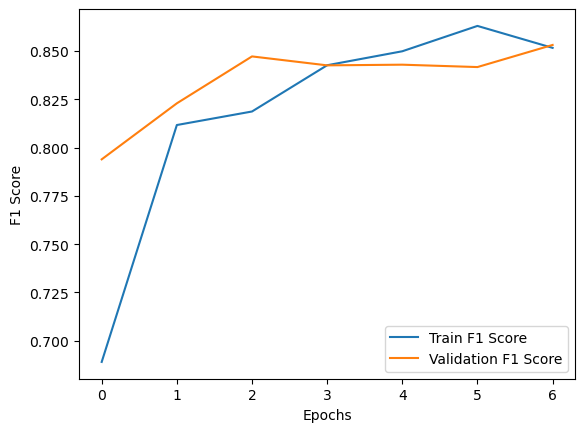

Epoch 8/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.99it/s]
Epoch 8/20, Train Loss: 0.3209, Val Loss: 0.3241, Train Acc: 86.41%, Val Acc: 85.37%


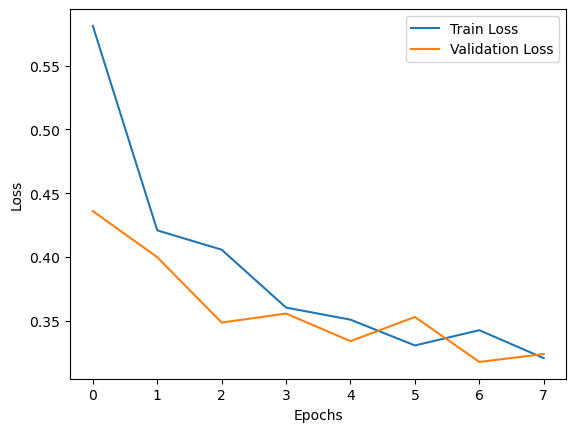

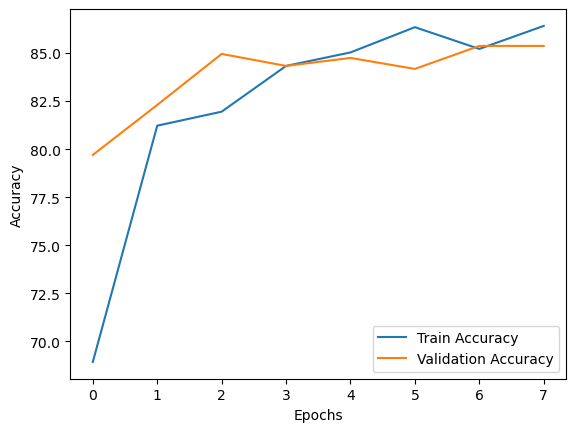

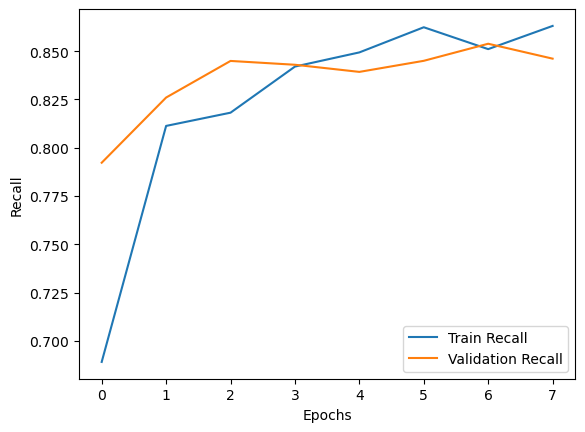

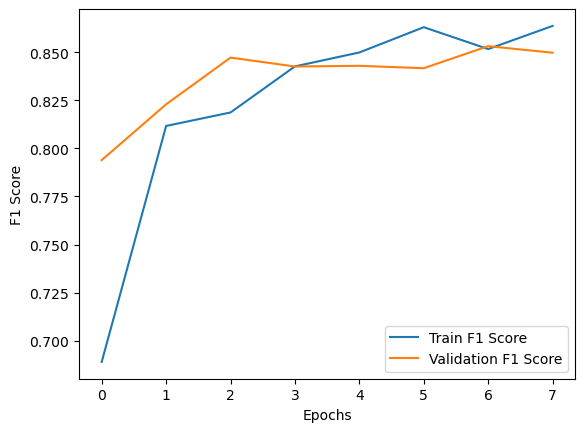

Epoch 9/20 - Validation: 100%|█████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.64it/s]
Epoch 9/20, Train Loss: 0.3272, Val Loss: 0.3024, Train Acc: 85.78%, Val Acc: 87.19%


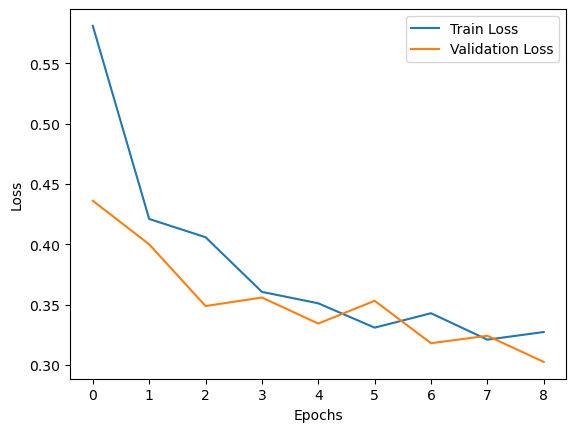

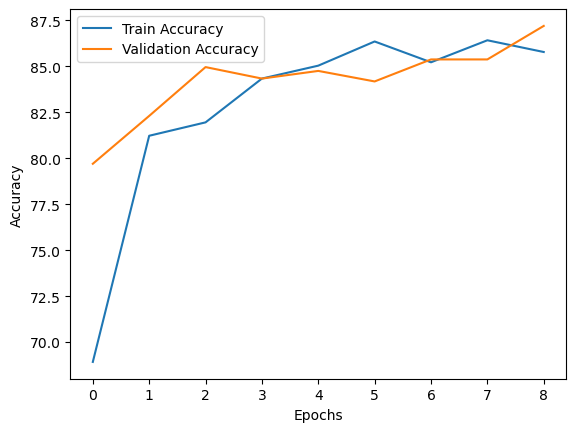

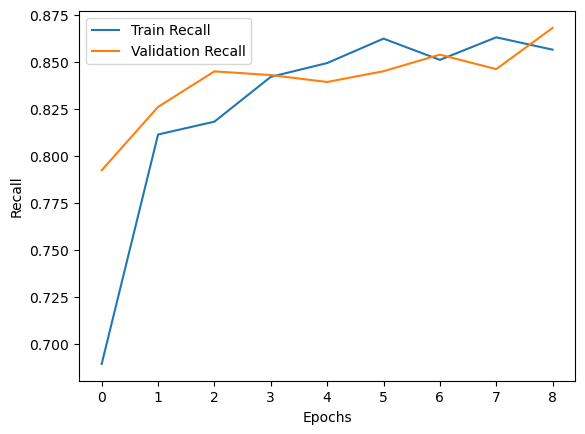

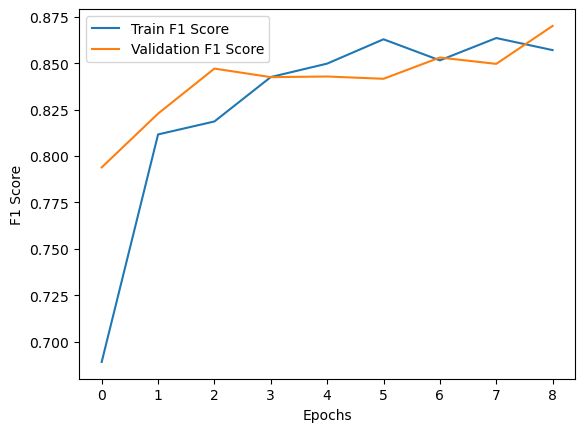

Epoch 10/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.69it/s]
Epoch 10/20, Train Loss: 0.3079, Val Loss: 0.3124, Train Acc: 87.05%, Val Acc: 86.47%


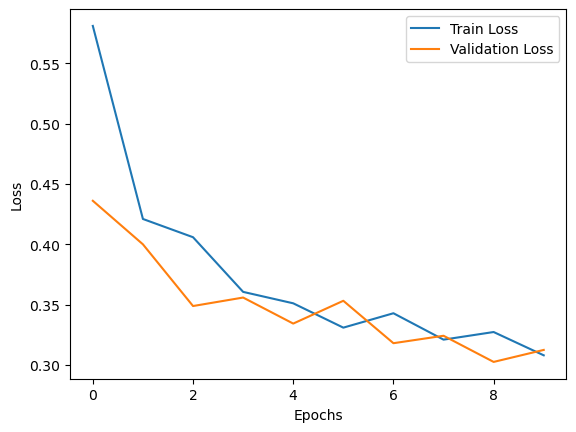

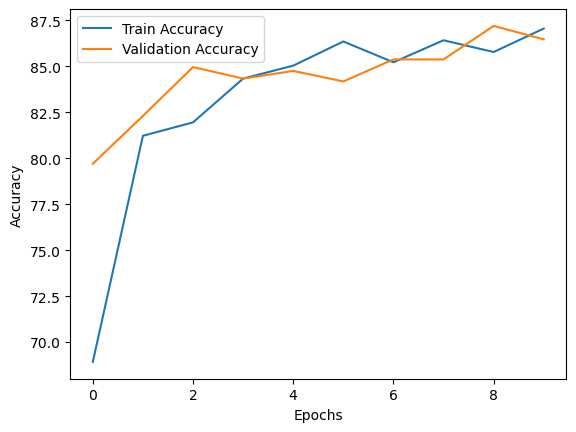

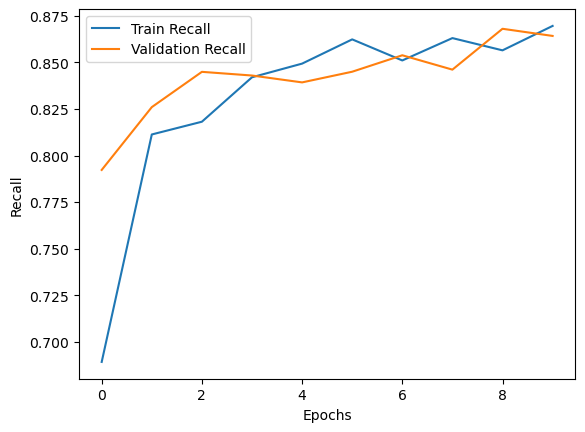

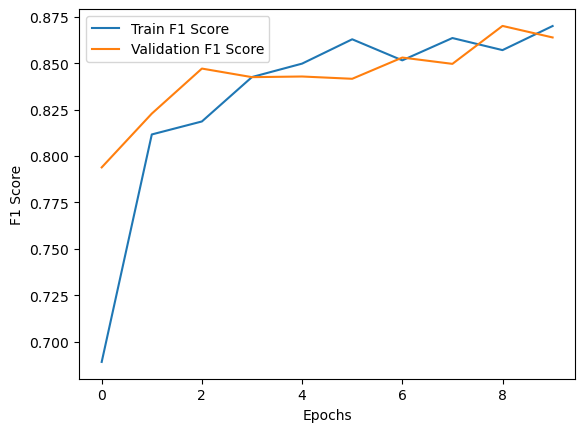

Epoch 11/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.47it/s]
Epoch 11/20, Train Loss: 0.3012, Val Loss: 0.2928, Train Acc: 87.79%, Val Acc: 87.35%


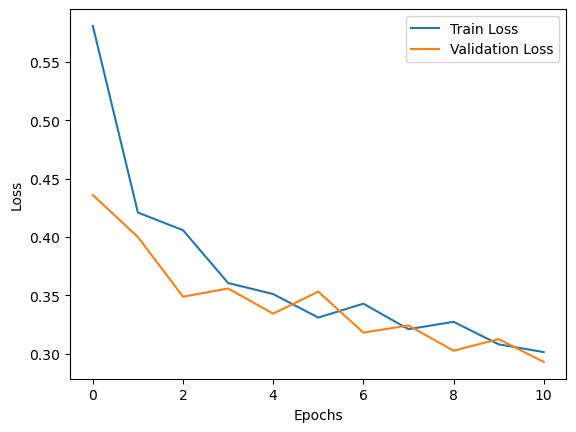

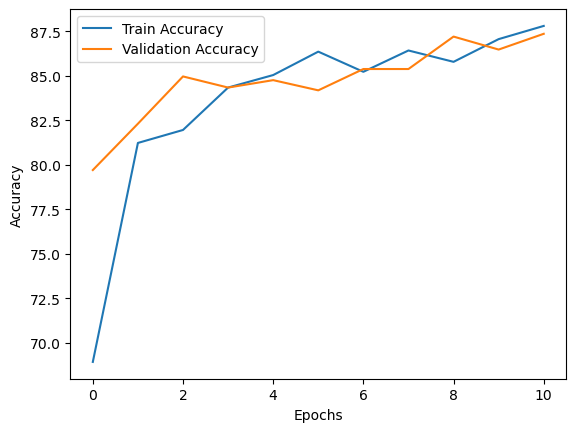

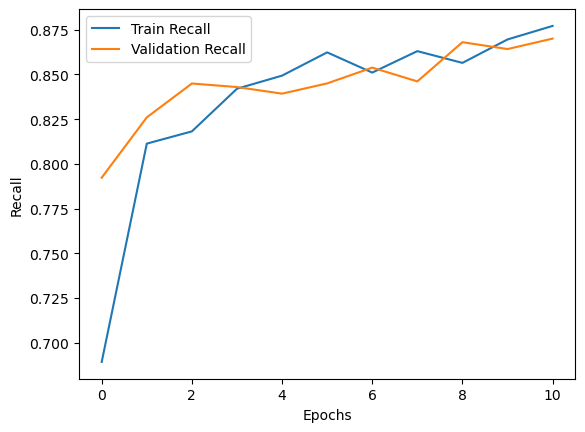

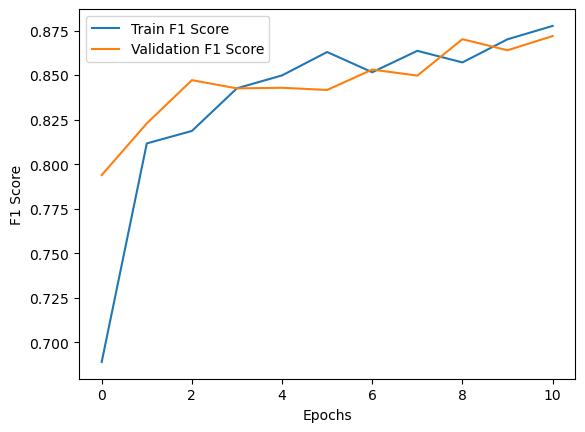

Epoch 12/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.52it/s]
Epoch 12/20, Train Loss: 0.3035, Val Loss: 0.2907, Train Acc: 87.23%, Val Acc: 87.61%


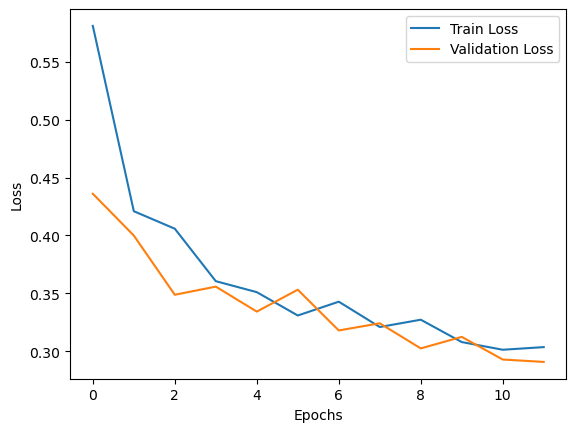

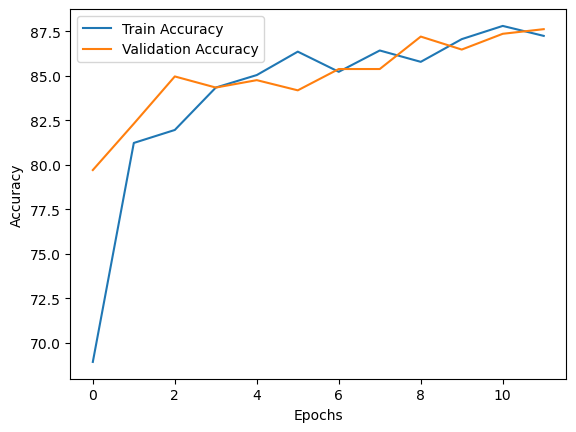

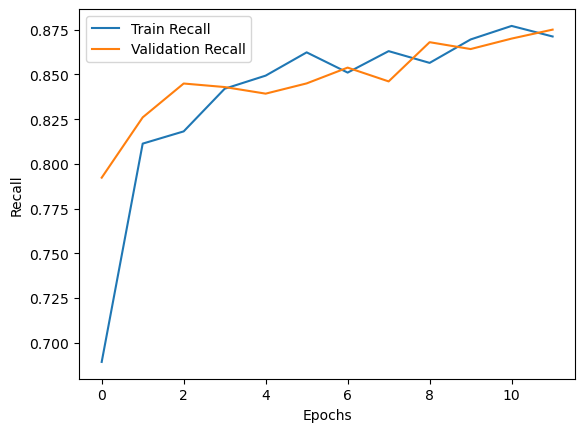

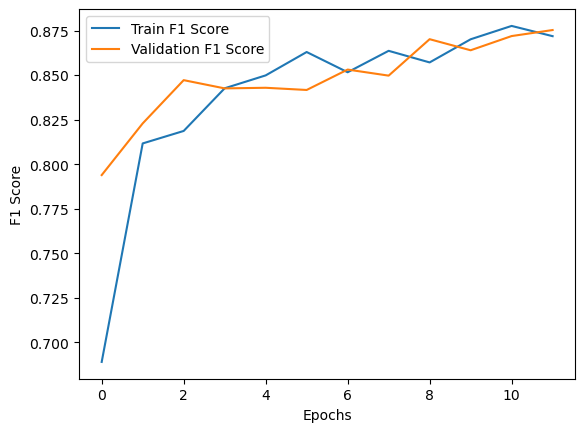

Epoch 13/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.67it/s]
Epoch 13/20, Train Loss: 0.2985, Val Loss: 0.3461, Train Acc: 87.47%, Val Acc: 86.00%


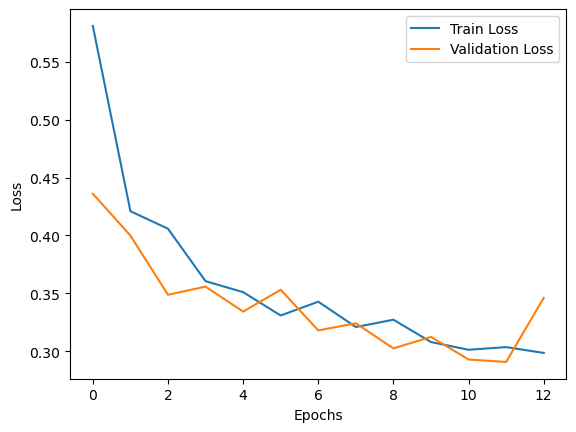

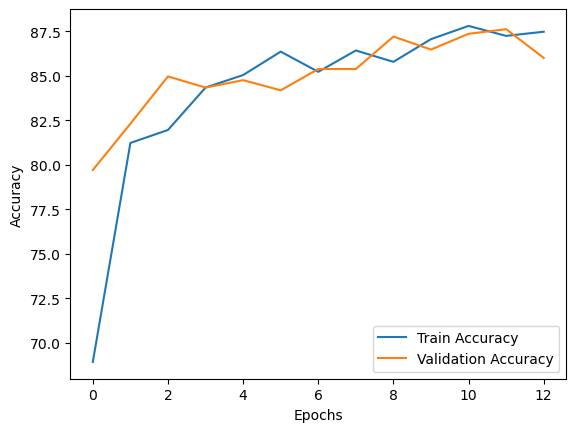

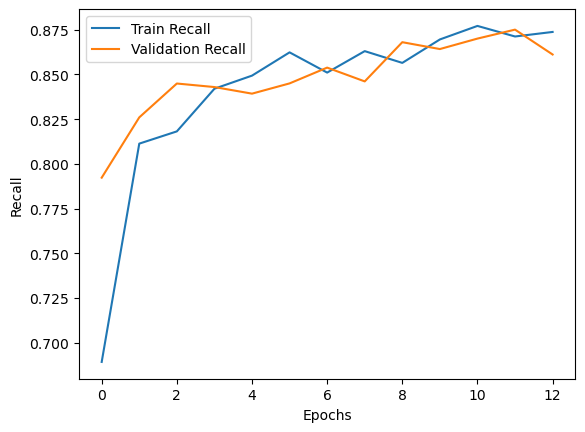

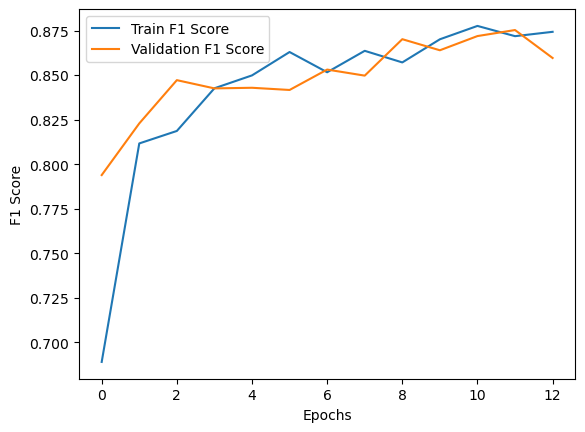

Epoch 14/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.66it/s]
Epoch 14/20, Train Loss: 0.2984, Val Loss: 0.3052, Train Acc: 87.09%, Val Acc: 87.51%


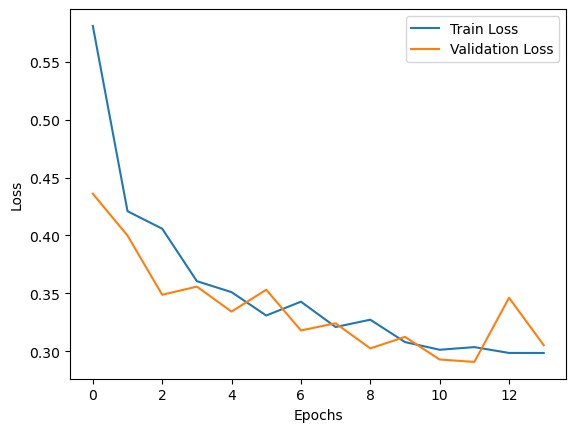

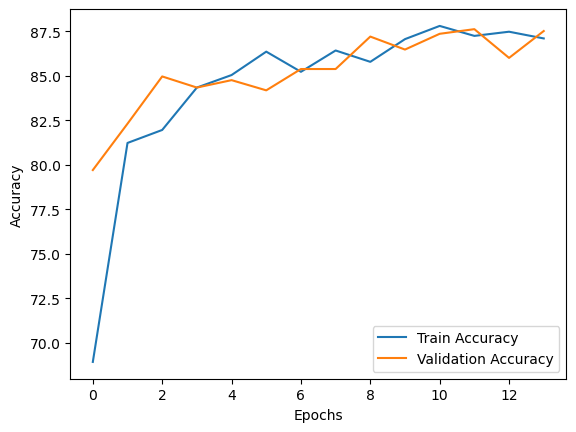

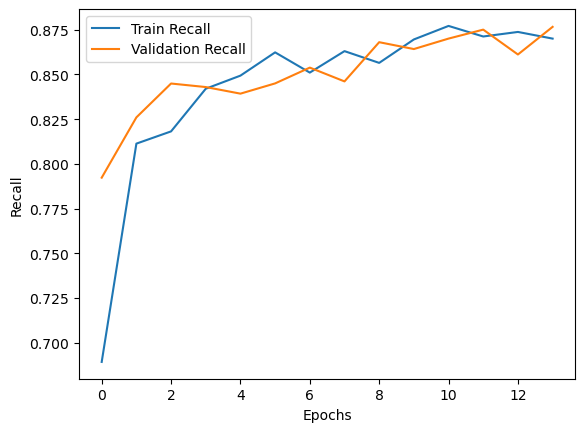

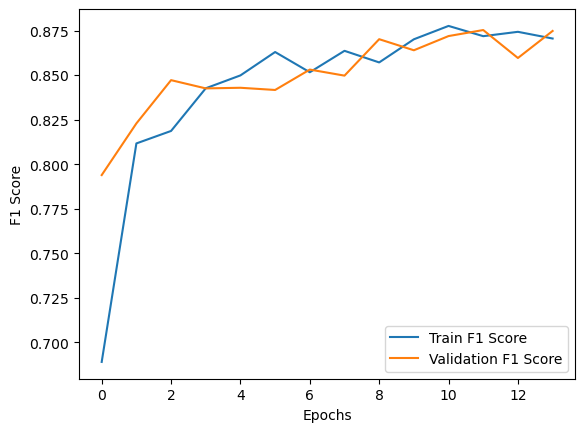

Epoch 15/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.75it/s]
Epoch 15/20, Train Loss: 0.2855, Val Loss: 0.2872, Train Acc: 87.91%, Val Acc: 87.56%


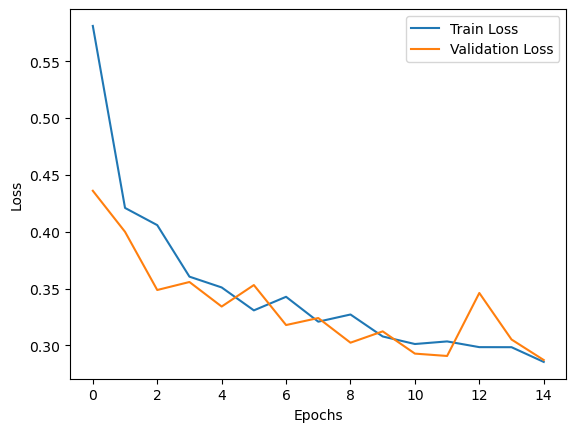

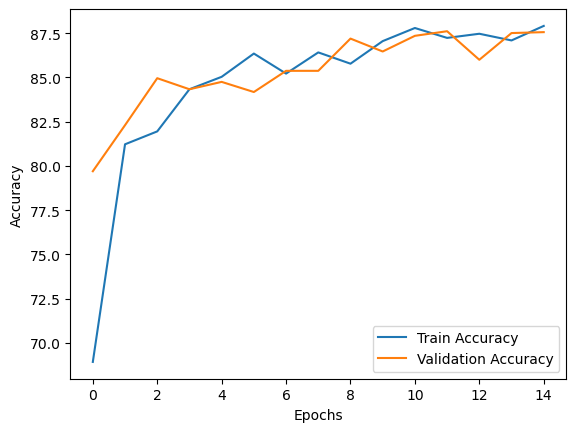

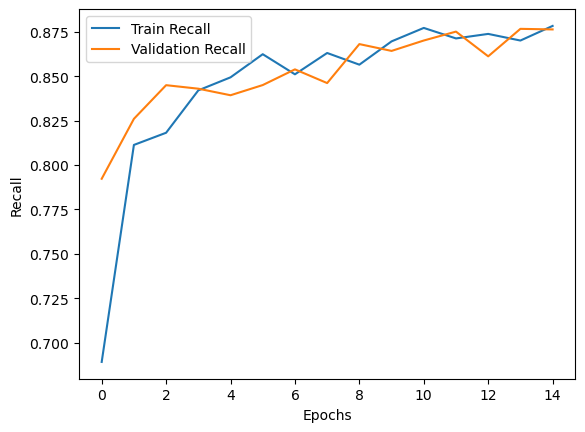

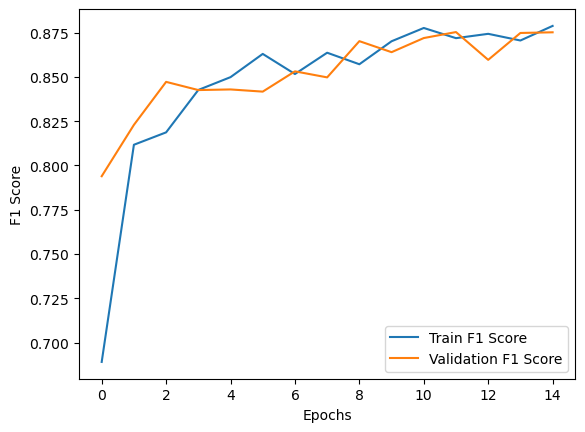

Epoch 16/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.67it/s]
Epoch 16/20, Train Loss: 0.2785, Val Loss: 0.2884, Train Acc: 88.05%, Val Acc: 87.51%


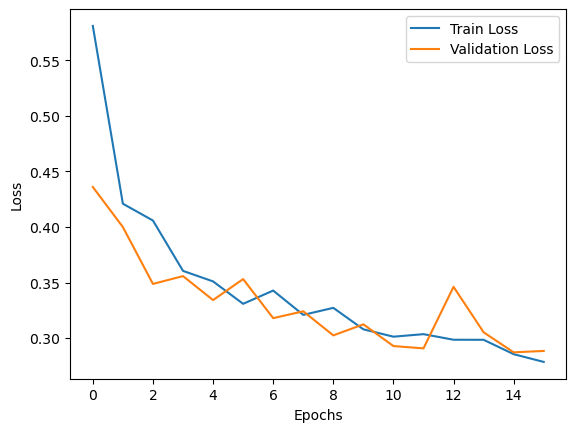

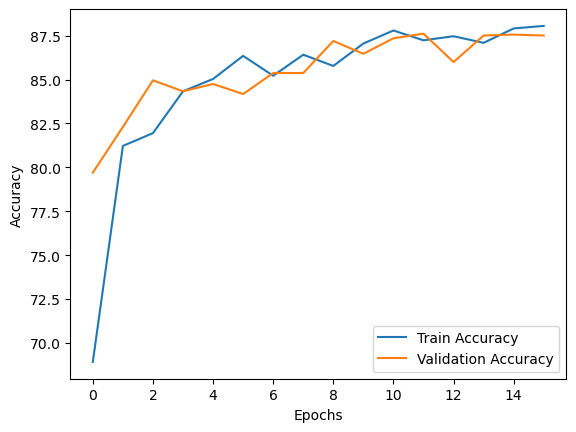

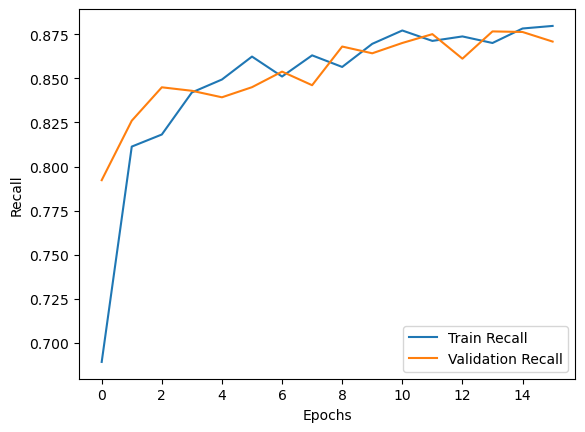

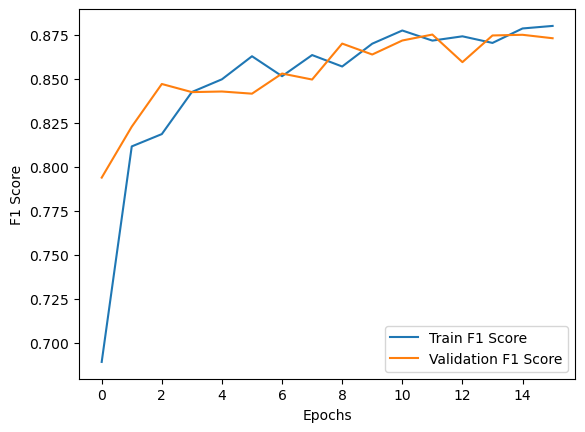

Epoch 17/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.57it/s]
Epoch 17/20, Train Loss: 0.2721, Val Loss: 0.2801, Train Acc: 88.05%, Val Acc: 87.14%


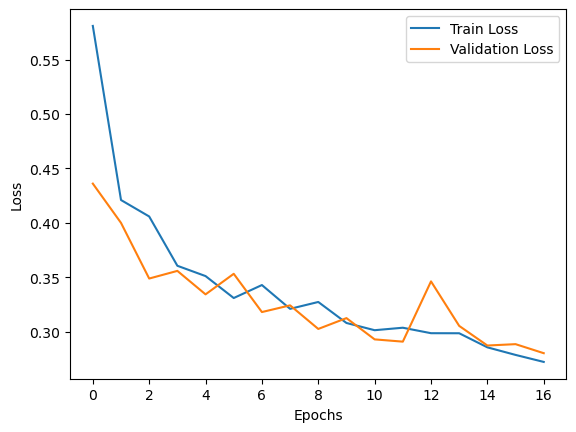

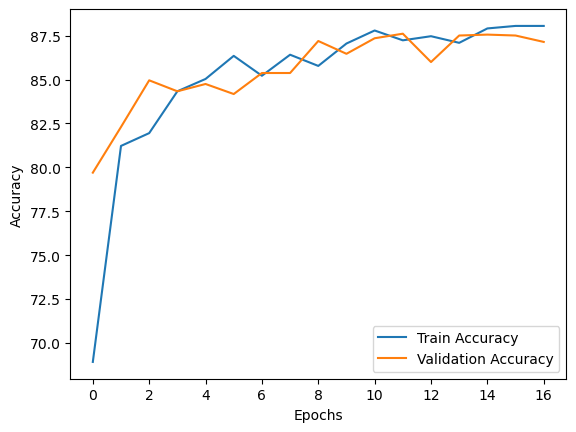

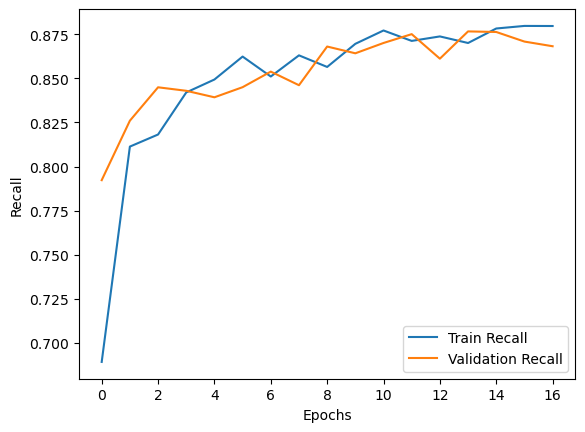

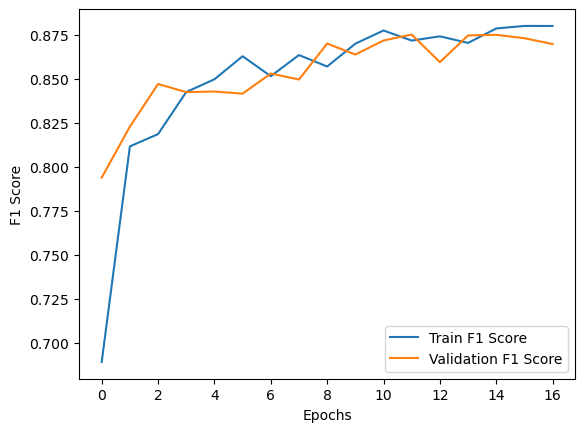

Epoch 18/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.22it/s]
Epoch 18/20, Train Loss: 0.2766, Val Loss: 0.2828, Train Acc: 88.64%, Val Acc: 88.34%


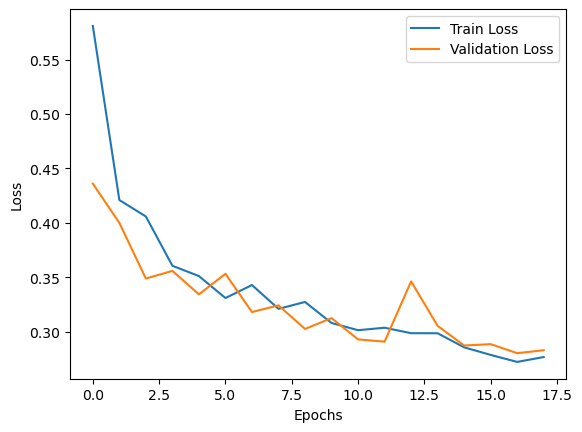

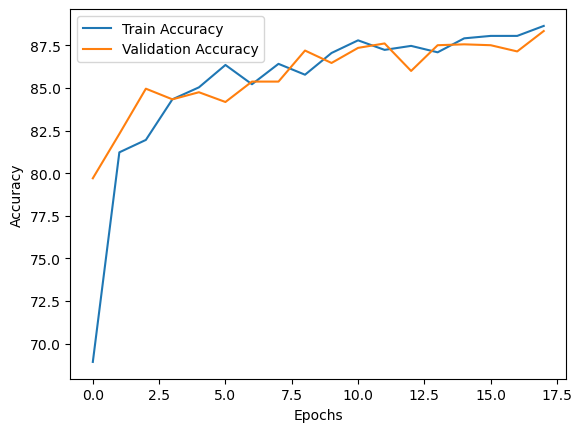

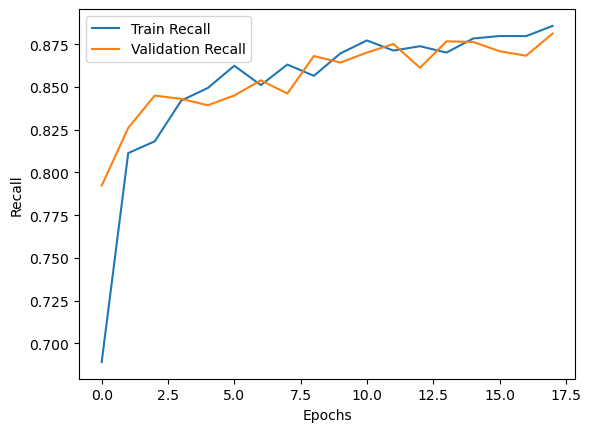

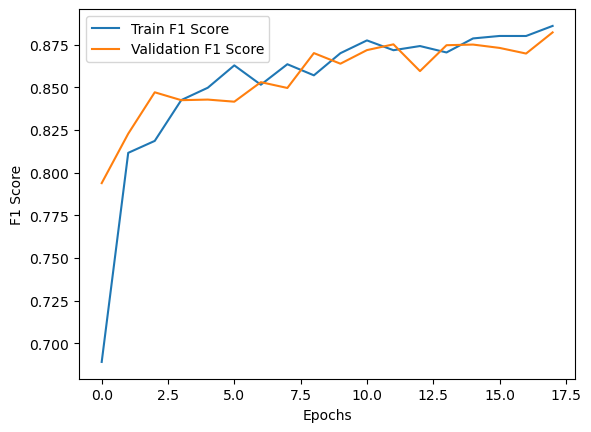

Epoch 19/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.62it/s]
Epoch 19/20, Train Loss: 0.2753, Val Loss: 0.2788, Train Acc: 88.34%, Val Acc: 88.86%


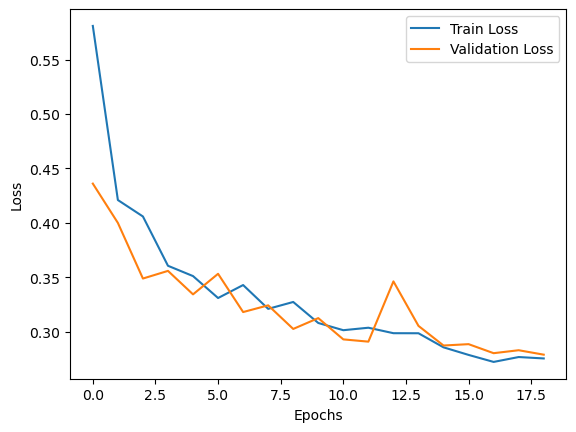

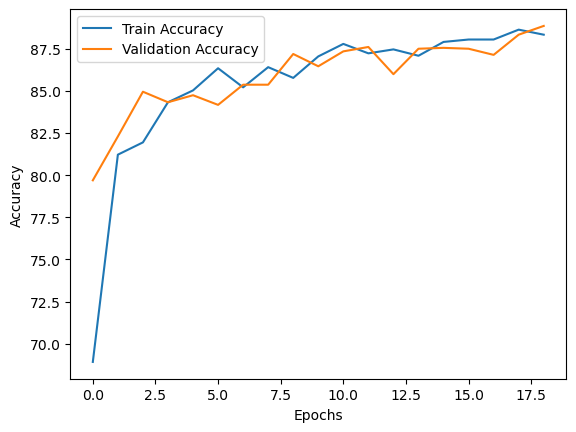

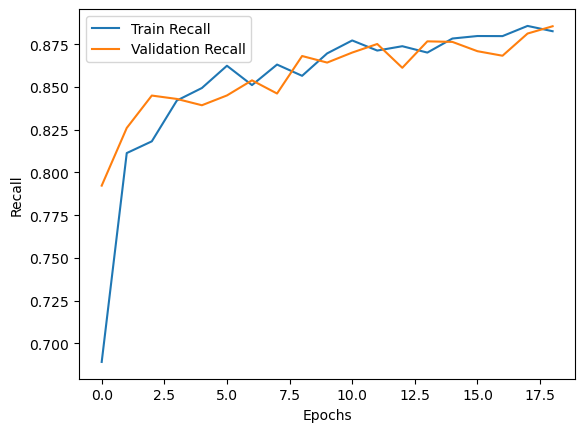

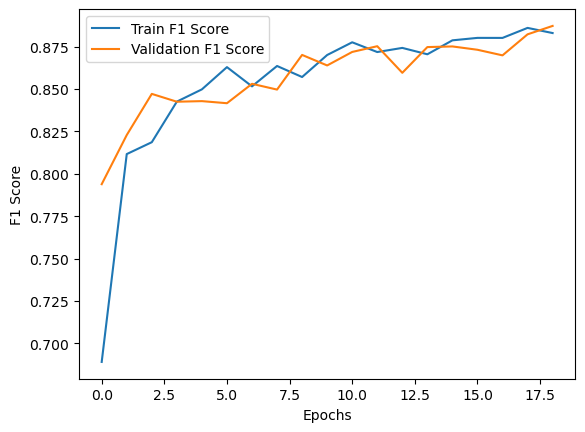

Epoch 20/20 - Validation: 100%|████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.78it/s]
Epoch 20/20, Train Loss: 0.2683, Val Loss: 0.2765, Train Acc: 88.70%, Val Acc: 87.71%


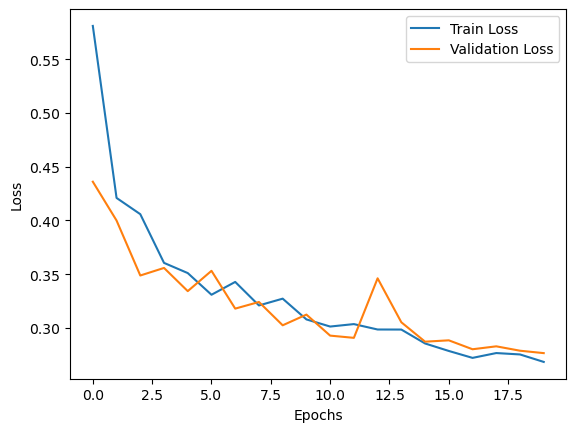

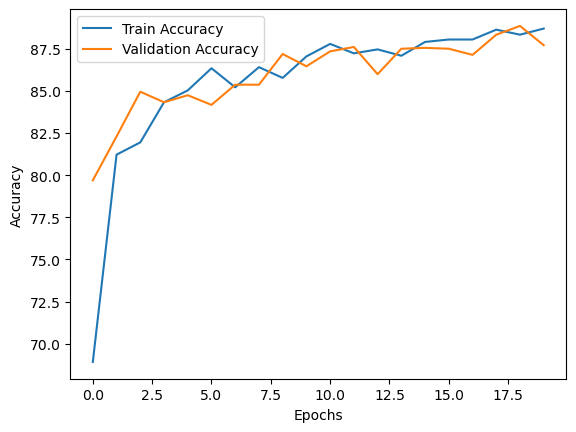

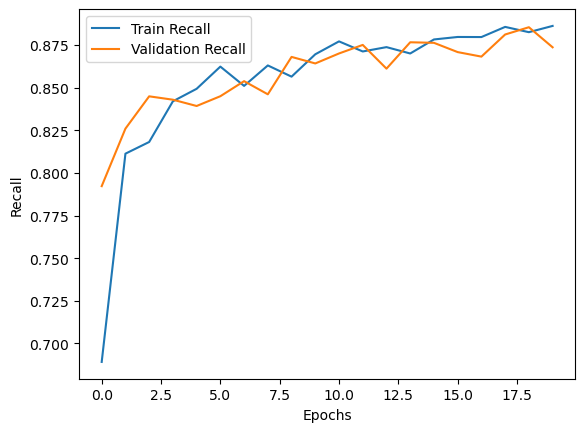

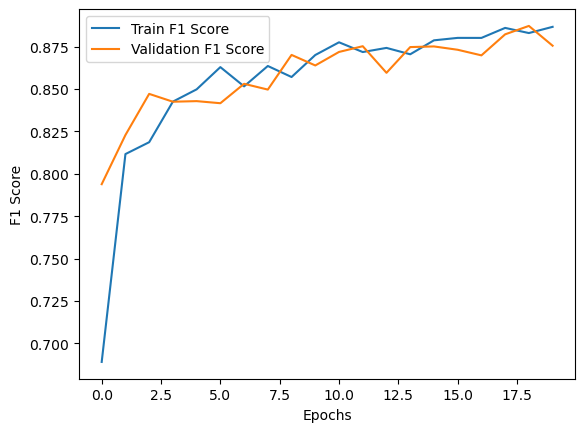

In [11]:
for epoch in range(num_epochs):
    # 训练模式
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    y_train_true = []
    y_train_pred = []
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移到GPU上
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(predicted.cpu().numpy())
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    train_recalls.append(recall_score(y_train_true, y_train_pred, average='macro'))
    train_f1s.append(f1_score(y_train_true, y_train_pred, average='macro'))
    
    # 验证模式
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    y_val_true = []
    y_val_pred = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(predicted.cpu().numpy())
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    val_recalls.append(recall_score(y_val_true, y_val_pred, average='macro'))
    val_f1s.append(f1_score(y_val_true, y_val_pred, average='macro'))
    
    # 调整学习率
    scheduler.step()
    
    # 早停机制
    if val_loss / len(val_loader) < best_val_loss:
        best_val_loss = val_loss / len(val_loader)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            logger.info(f"Early stopping at epoch {epoch+1}")
            break
    
    # 打印当前轮次的损失和准确率
    logger.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

    # 绘制并显示当前轮次的训练和验证损失曲线
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close()

    # 绘制并显示当前轮次的训练和验证准确率曲线
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
    plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.close()

    # 绘制并显示当前轮次的训练和验证召回率曲线
    plt.figure()
    plt.plot(range(len(train_recalls)), train_recalls, label='Train Recall')
    plt.plot(range(len(val_recalls)), val_recalls, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    plt.close()

    # 绘制并显示当前轮次的训练和验证F1分数曲线
    plt.figure()
    plt.plot(range(len(train_f1s)), train_f1s, label='Train F1 Score')
    plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    plt.close()


### 在测试集上进行预测和评估：

##### 计算并打印准确率、精确度、召回率和 F1 分数。
##### 绘制混淆矩阵。
##### 打印分类报告。

Test Accuracy: 0.911
Test Precision: 0.9146639708463988
Test Recall: 0.911
Test F1 Score: 0.9108029637469169


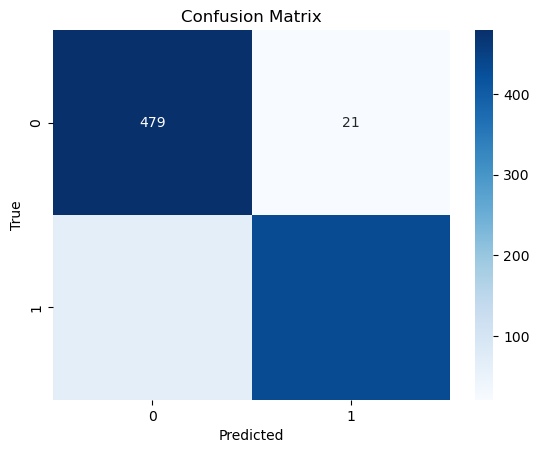


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.96      0.91       500
     Class 1       0.95      0.86      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [12]:
# 测试集上的预测和评估
model.eval()
y_test_pred = []
y_test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred, average='macro')
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.close()

# 打印分类报告
class_report = classification_report(y_test_true, y_test_pred, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n", class_report)


#### 最后，绘制并显示训练和验证的损失曲线、准确率曲线、召回率曲线和 F1 分数曲线，展示模型在训练过程中的表现。

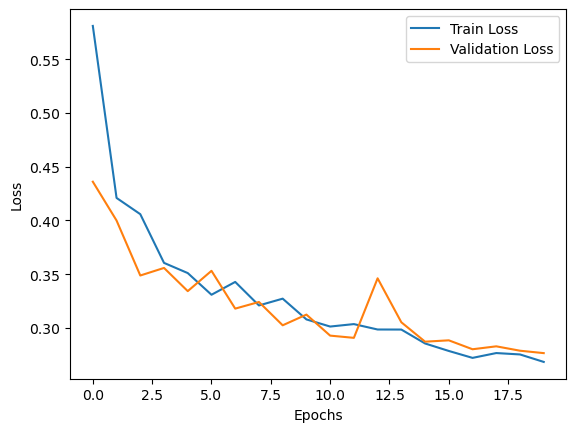

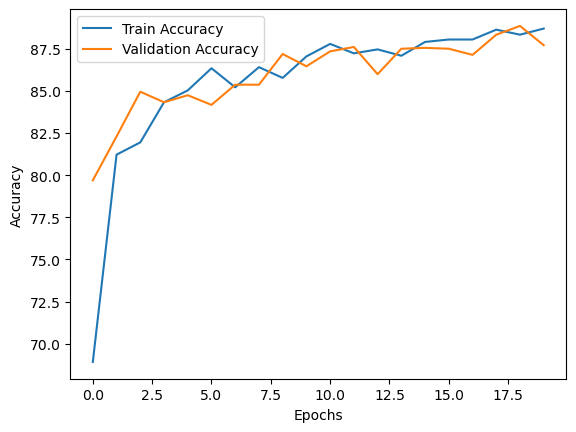

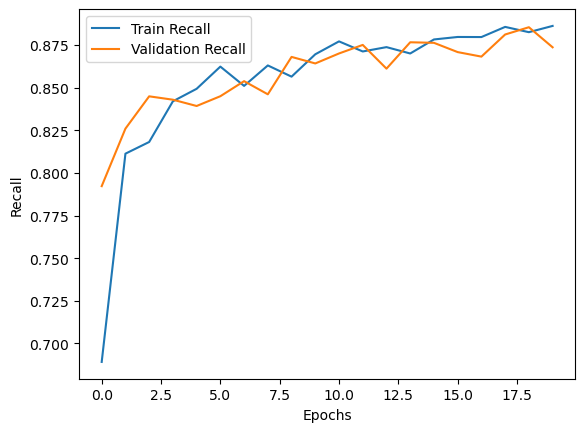

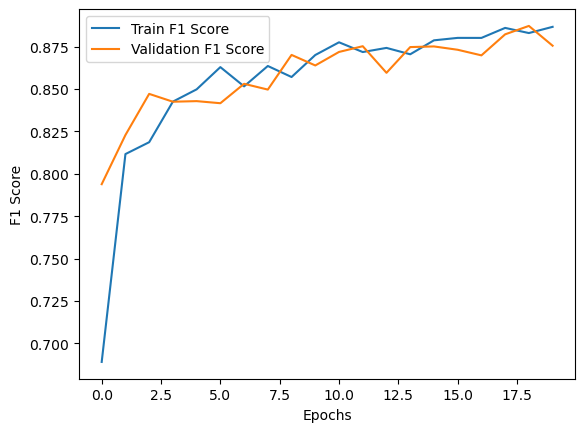

In [13]:
# 绘制训练和验证的损失曲线
plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

# 绘制训练和验证的准确率曲线
plt.figure()
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

# 绘制训练和验证的召回率曲线
plt.figure()
plt.plot(range(len(train_recalls)), train_recalls, label='Train Recall')
plt.plot(range(len(val_recalls)), val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()
plt.close()

# 绘制训练和验证的F1分数曲线
plt.figure()
plt.plot(range(len(train_f1s)), train_f1s, label='Train F1 Score')
plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()
plt.close()
